similar to cases_study_heat.ipynb 

Feb 2021 event (February 13–17, 2021 North American winter storm):
 - minumum temperature during the event
 - Number of days with Tmin<0 for the event
casper_2020

In [12]:
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import geoplot as gplt

In [13]:
dir_prism = '/glade/campaign/mmm/c3we/prein/observations/PRISM/data/'
dir_o = '/glade/campaign/mmm/c3we/mingge/INNOVATOR/'

####  geospatial plot
Because of high resolution shapefile, there is no PRISM grid inside a lot of shapes. I calculate the centroid of those polygons and then use the nearest prism grid data

In [14]:
flnm_shp = '/glade/work/mingge/SHAPEFILES/COUNTY_OREGON/sovi_3county_SD/sovi_3_county.shp'
shp_gpd = gpd.read_file(flnm_shp)

#crs={'init':'epsg:4326'}
#### convert everything to latitude and longitude in geometry
####  "EPSG:4326" : CRS=WGS84 latitude-longitude projection
shp_gpd = shp_gpd.to_crs('EPSG:4326')

# Get lat-lon of geodataframe polygon, and then add them back
# I use centroid of the shape
#  reproject geodataframe to a geographic CRS, e.g EPSG:4326 
# nc_counties = shp_gpd.to_crs(4326)
#shp_gpd = shp_gpd.set_crs('EPSG:4326')
shp_gpd['lon_centroid'] = shp_gpd.centroid.x  
shp_gpd['lat_centroid'] = shp_gpd.centroid.y

n_shp = len(shp_gpd.centroid)

/glade/scratch/mingge/ipykernel_175393/554569368.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp_gpd['lon_centroid'] = shp_gpd.centroid.x
/glade/scratch/mingge/ipykernel_175393/554569368.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp_gpd['lat_centroid'] = shp_gpd.centroid.y
/glade/scratch/mingge/ipykernel_175393/554569368.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  n_shp = len(shp_gpd.centroid)


#### Feb 2021 event (February 13–17, 2021 North American winter storm):
https://en.wikipedia.org/wiki/February_13%E2%80%9317,_2021_North_American_winter_storm

In [15]:
date_st = '2021-02-13'
date_end = '2021-02-17'
date_s = pd.date_range(date_st, date_end, freq='D').format(formatter=lambda x: x.strftime('%Y%m%d'))

ds = xr.open_dataset(dir_prism + 'Tmax/PRISM_daily_tmax_2021.nc')
tmax_3d = ds.sel(time=slice(date_st, date_end)).isel(rlat=slice(88,122), rlon=slice(26, 82)) .Tmax

ds = xr.open_dataset(dir_prism + 'Tmin/PRISM_daily_tmin_2021.nc')
tmin_3d = ds.sel(time=slice(date_st, date_end)).isel(rlat=slice(88,122), rlon=slice(26, 82)).Tmin

ds = xr.open_dataset(dir_prism + 'PR/PRISM_daily_ppt_2021.nc')
prec_3d = ds.sel(time=slice(date_st, date_end)).isel(rlat=slice(88,122), rlon=slice(26, 82)).PR
 
ice_3d = prec_3d.where(tmin_3d<0, drop=False)
 
n_day = tmax_3d.shape[0]

#maximum temperature (maximum over all days of the heatwave event).
tmin_2d = tmin_3d.min(dim='time') 

#### lowest Tmin over all days fo the Feb event (coldest night)

In [16]:
tmin_1d = np.zeros((n_shp))
for nn in range(n_shp):
    lat_0 = shp_gpd['lat_centroid'][nn]
    lon_0 = shp_gpd['lon_centroid'][nn]
    t = tmin_2d.sel(rlon=lon_0, rlat=lat_0, method="nearest")
    tmin_1d[nn]=t.values
    
shp_gpd['tmin'] = tmin_1d  

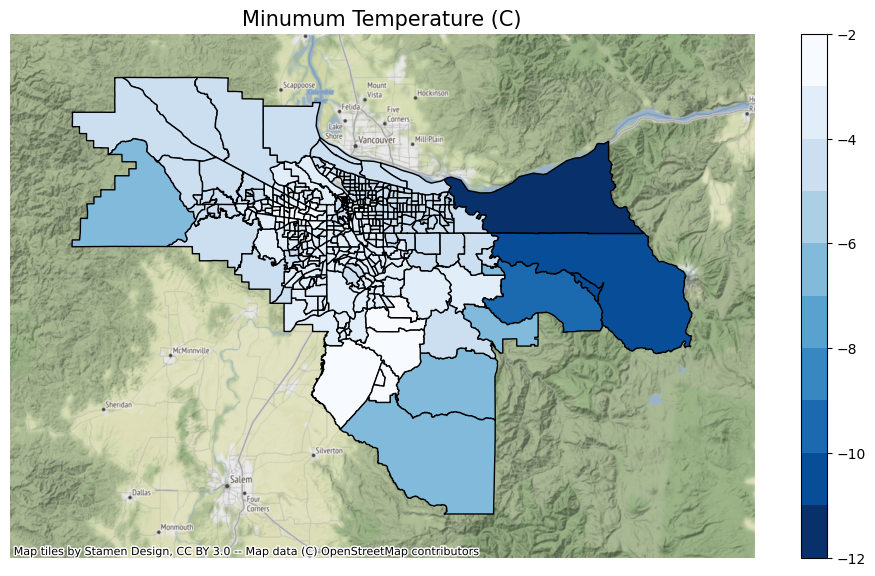

In [48]:
import contextily as cx
ax = gplt.polyplot(shp_gpd, figsize=(12, 8))
cx.add_basemap(ax = ax, crs=shp_gpd.crs) 
ax.set_title('Minumum Temperature (C)', size = 15)
shp_gpd.plot(ax=ax, column='tmin', edgecolor="black",
             cmap=plt.cm.get_cmap('Blues_r', 10),
             legend=True,legend_kwds={"shrink":.85}, vmin=-12, vmax=-2);  
#shp_gpd.plot(ax=ax, column='tmin', cmap = 'Blues', legend=True) #, scheme="quantiles");
plt.savefig(dir_o + 'PLOT/tmin_winterstorm_2021.png', bbox_inches='tight')

In [ ]:
https://github.com/geopandas/geopandas/issues/961

#### Number of days with Tmin<0 for the event

In [7]:
from innovator_func import add_shape_coord_from_data_array
# Create a new coord for the ds indicating whether or not it is inside the shapefile
ds_da = add_shape_coord_from_data_array(ds.isel(time=0).isel(rlat=slice(88,122), rlon=slice(26, 82)), shp_gpd, "county")
county_2d = ds_da.county
#county_2d.plot()

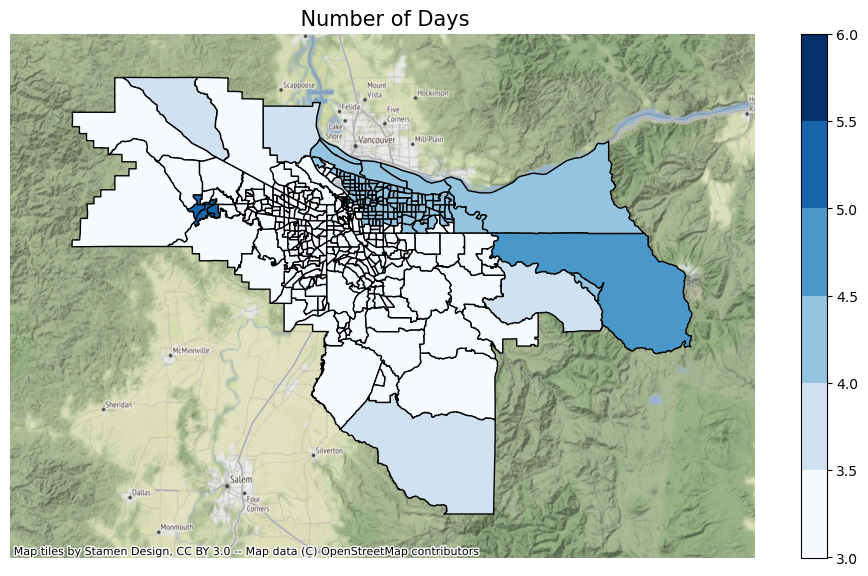

In [50]:
n_ice_3d = xr.where(tmin_3d<0, 1, 0)
n_ice_2d = n_ice_3d.sum(dim='time') 

list_1d = []

for nn in range(n_shp):
    t_mean = n_ice_2d.where(county_2d==nn, other=np.nan).mean(dim=('rlat', 'rlon')).values
    if np.isnan(t_mean):
        # when there is no grid point within the shape, use the nearest grid
        lat_0 = shp_gpd.lat_centroid[nn]
        lon_0 = shp_gpd.lon_centroid[nn]
        t = n_ice_2d.sel(rlon=lon_0, rlat=lat_0, method="nearest")
        list_1d.append(t.values)
    else:
        list_1d.append(t_mean)

### NOTE:  use numpy array
shp_gpd['Nid'] = np.rint(np.asarray(list_1d))
shp_gpd['Nid'] = np.asarray(list_1d)

import contextily as cx
ax = gplt.polyplot(shp_gpd, figsize=(12, 8))
cx.add_basemap(ax = ax, crs=shp_gpd.crs) 
ax.set_title(' Number of Days', size = 15)
 
shp_gpd.plot(ax=ax, column='Nid', edgecolor="black",
             cmap=plt.cm.get_cmap('Blues', 6),
             vmin = 3, vmax = 6,legend=True,legend_kwds={"shrink":.85}) 
plt.savefig(dir_o + '/PLOT/NumIceDay_winterstorm_2021.png', bbox_inches='tight')

#### save to shapefile

In [9]:
shp_gpd.to_file(dir_o + "DATA/winterstorm_2021.shp")

/glade/work/mingge/miniconda3/envs/casper_2020/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/glade/scratch/mingge/ipykernel_175393/1807765183.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_gpd.to_file(dir_o + "DATA/winterstorm_2021.shp")
